In [1]:
import numpy as np
import matplotlib
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
#import nipy
from nipy.labs.mask import compute_mask
from skimage import exposure, img_as_float
from skimage.exposure import rescale_intensity, adjust_gamma, equalize_adapthist
#from scipy import stats
#import pandas as pd
import tifffile as tiff

%load_ext autoreload
%autoreload 2

In [2]:
animal = 'CHATM2'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}'
INPUT = os.path.join(DIR, 'preps', 'CH2', 'thumbnail')
files = sorted(os.listdir(INPUT))

In [20]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import remove_strip, place_image, trim_edges, fix_with_fill, get_binary_mask, scaled, equalized, fix_with_blob,create_mask_pass1
from utilities.sqlcontroller import SqlController
sqlController = SqlController(animal)

In [ ]:
bad = []
bads = ['{}.tif'.format(str(i).zfill(3)) for i in bad]
print(f'Need to manually fix {len(bads)} files or %{100*len(bads)/len(files)}')

100%|██████████| 10/10 [00:00<00:00, 24.30it/s]


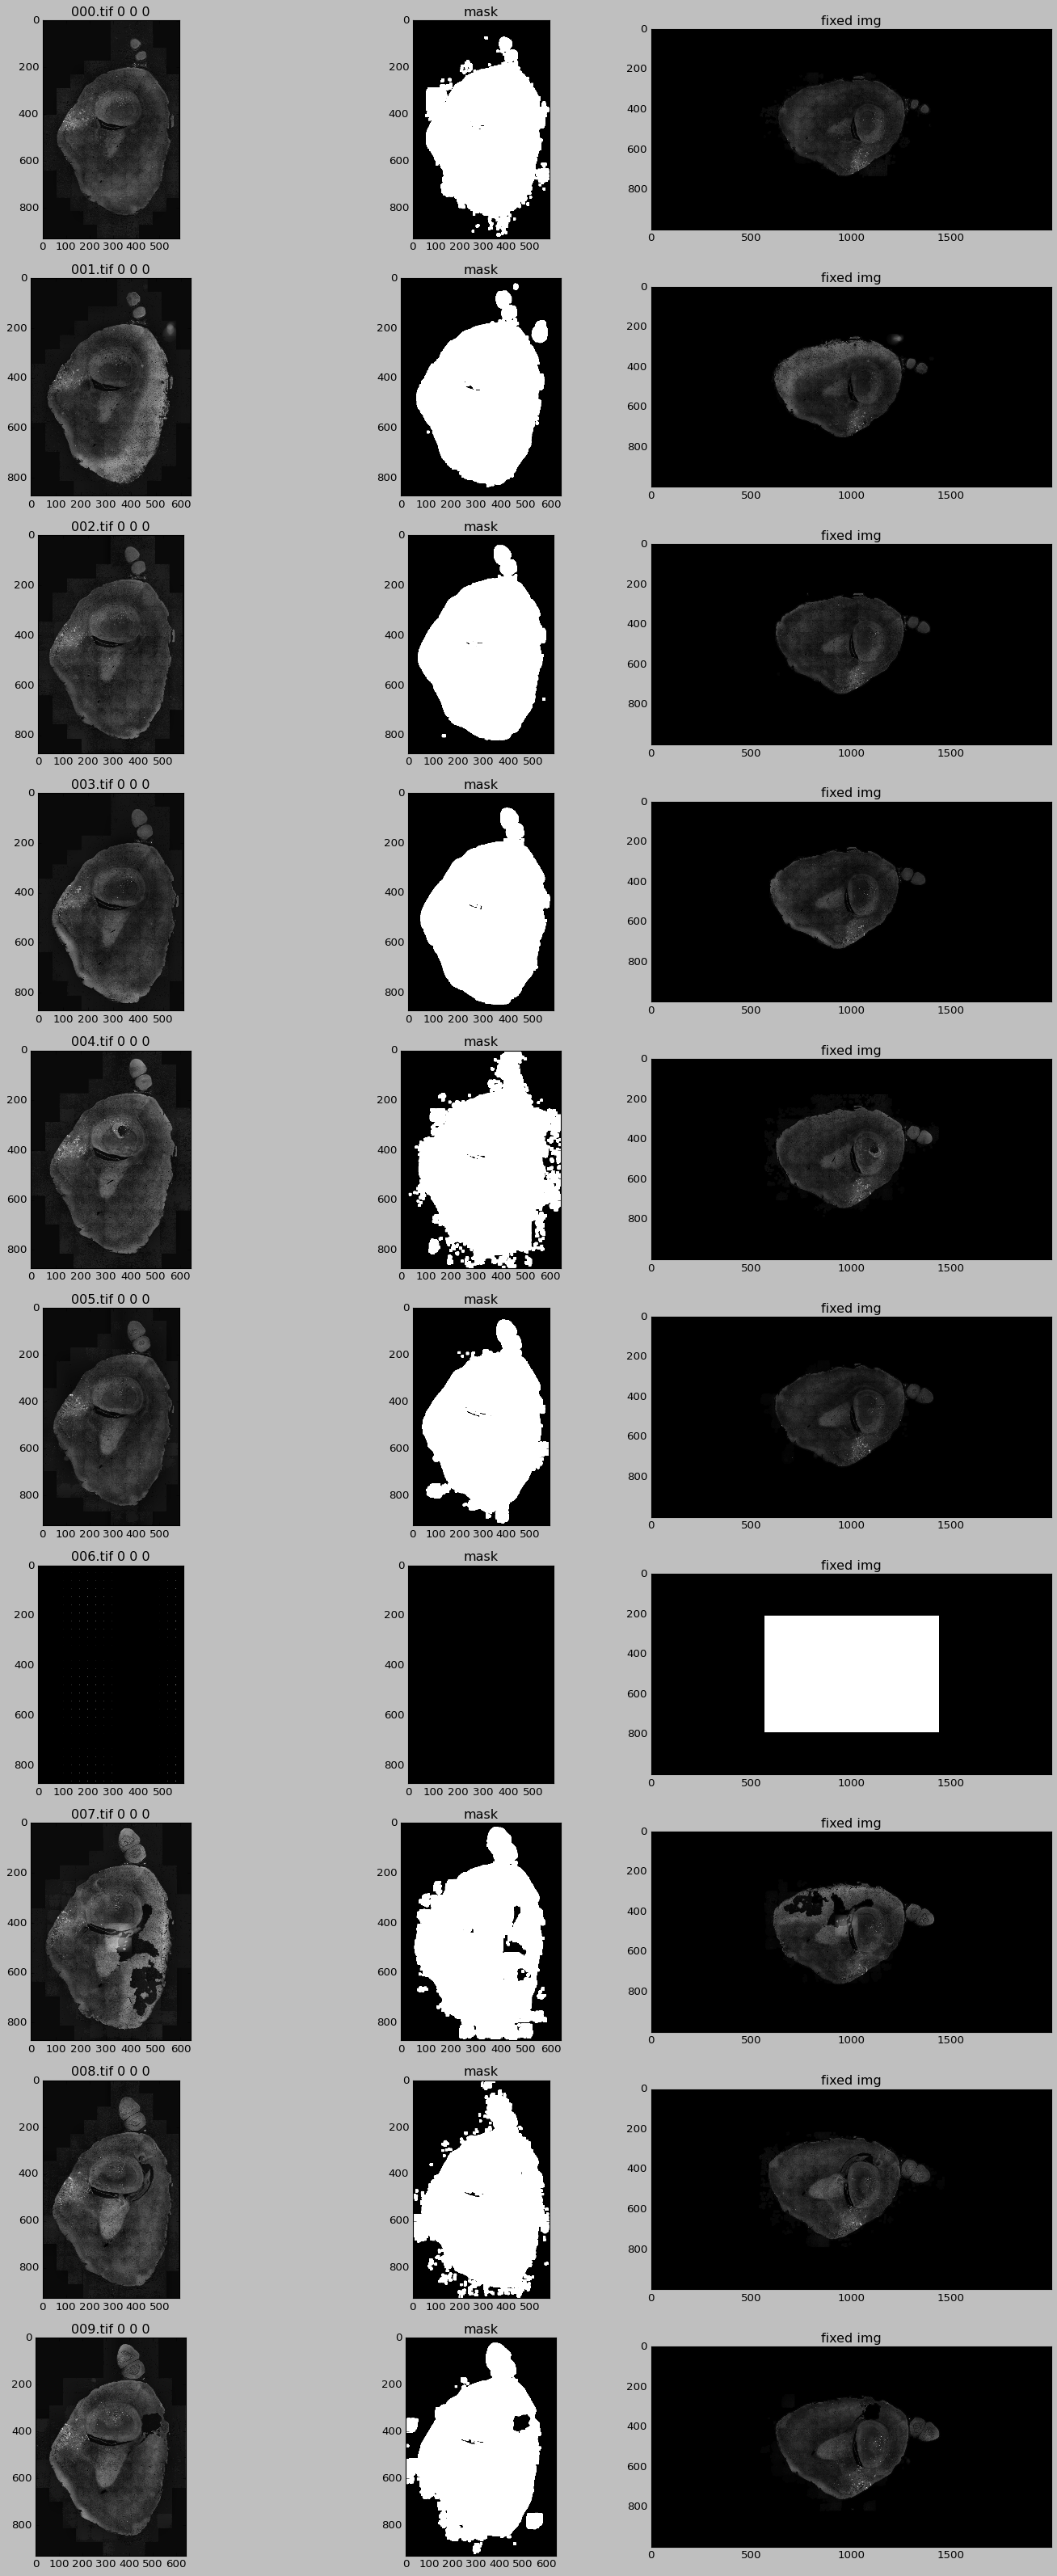

In [21]:
names = []
norms = []
masks = []
fixes = []
start, finish = (0,10)
lowVal, highVal, threshold = (0,0,0)
max_width = 2000
max_height = 1000

for file in tqdm(files[start:finish]):
    infile = os.path.join(INPUT, file)
    #img = io.imread(infile, plugin='matplotlib')
    img = io.imread(infile)
    img, _ = remove_strip(img)
    orig = img.copy()
    img = (img / 256).astype(np.uint8)
    normed = equalized(img)
    norms.append(normed)
    #mask1 = create_mask_pass1(img)
    #pass1 = cv2.bitwise_and(img, img, mask=mask1)
    ## pass2
    #pass1 = cv2.GaussianBlur(pass1,(133,133),0)
    #mask2 = fix_with_fill(pass1)    
    #mask3 = get_binary_mask(img)
    #fixed = cv2.bitwise_and(img, img, mask=mask3)
    #fixed = scaled(fixed, mask2)
    #fixed = equalized(fixed)
    mask = compute_mask(img, m=0.2, M=0.9, cc=False, opening=2, exclude_zeros=True)
    mask = mask.astype(int)
    mask[mask==0] = 0
    mask[mask==1] = 255
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)
    mask = mask.astype(np.uint8)
    fixed = cv2.bitwise_and(orig, orig, mask=mask)

    masks.append(mask)    
    name = f'{file} {round(lowVal)} {round(highVal)} {round(threshold)}'
    names.append(name)
    
    fixed = equalized(fixed)
    fixed = np.rot90(fixed, 3, axes=(1,0))
    fixed = np.flip(fixed, axis=1)
    fixed = place_image(fixed, file, max_width, max_height, 0)
    
    fixes.append(fixed)
    
fig, ax = plt.subplots(nrows=len(names), ncols=3, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask, fixed in zip(names, norms, masks, fixes):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('mask')
    ax[i,1].imshow(mask, cmap="gray")
    ax[i,2].set_title('fixed img')
    ax[i,2].imshow(fixed, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=False)
plt.tight_layout()
plt.show()

In [ ]:
for file in tqdm(files):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    mask = compute_mask(img, m=0.2, M=0.9, cc=False, opening=2, exclude_zeros=True)
    mask = mask.astype(int)
    mask[mask==0] = 0
    mask[mask==1] = 255
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)
    mask = mask.astype(np.uint8)
    fixed = cv2.bitwise_and(img, img, mask=mask)
    fixed = equalized(fixed)


In [ ]:
cv2.IMREAD_UNCHANGED

In [ ]:
# 181, very dark
# 381, kinda light
file = '000.50.tif' 
infile = os.path.join(INPUT, file)

#img = tiff.imread(infile)
#print('tifffile', img.shape, img.dtype, img.ndim)
#del img
#img = io.imread(infile, plugin='tifffile')
#print('io tiff', img.shape, img.dtype, img.ndim)
#del img
img = cv2.imread(infile, cv2.IMREAD_UNCHANGED)
print(type(img))
print('cv2', img.shape, img.dtype, img.ndim)
del img



#ch1 = img[:,:,0]
#ch2 = img[:,:,1]
#ch3 = img[:,:,2]
#print('ch1',ch1.shape, ch1.dtype)
#print('ch2',ch2.shape, ch2.dtype)
#print('ch3',ch3.shape, ch3.dtype)

"""
mask = compute_mask(img, m=0.2, M=0.9, cc=False, opening=2, exclude_zeros=True)
mask = mask.astype(int)
mask[mask==0] = 0
mask[mask==1] = 255
kernel = np.ones((5, 5), np.uint8)
mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)
mask = mask.astype(np.uint8)

#fixed = img.copy()
print(mask.shape, mask.dtype)
#fixed[fixed < 50] = 0
fixed = cv2.bitwise_and(img, img, mask=mask)


# figure size in inches optional
rcParams['figure.figsize'] = 18 ,18
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap="gray");
ax[0].set_title('original')
ax[1].imshow(fixed, cmap="gray");
ax[1].set_title('fixed')
"""
